<a href="https://colab.research.google.com/github/Cairo-Henrique/BQC-Quantum-Tech/blob/main/Bloco_1/BQC_Aula_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brazil Quantum Camp

**Aula 7** Construção de Circuitos Quânticos com IBM Qiskit

In [ ]:
# Descomente a próxima linha para instalar as dependências necessárias no Colab.
!pip install qiskit[visualization]==2.2.3 qiskit-aer==0.17.2 qiskit-ibm-runtime==0.44.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.6/378.6 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 12.4 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=714f5a14df27ba7a0e7f3277f9e45cdfef28f339eccafa2a9146f241b4544e9a
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178

In [ ]:
from qiskit import (
    QuantumRegister,
    ClassicalRegister,
    QuantumCircuit,
    generate_preset_pass_manager,
)
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit_ibm_runtime import Sampler, Estimator, QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram


import numpy as np

# Código Apresentado em Aula

## **Visualização** do Circuito

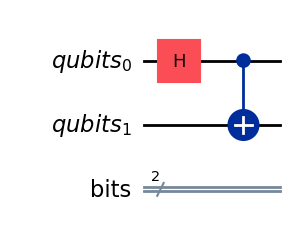

In [ ]:
qubits = QuantumRegister(2, name="qubits")
bits = ClassicalRegister(2, name="bits")
qc = QuantumCircuit(qubits, bits)
qc.h(0)
qc.cx(0, 1)
qc.draw("mpl")

## De Circuito para **Porta**

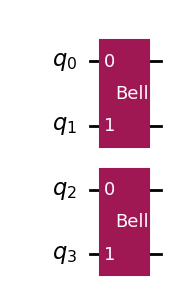

In [ ]:
# 1. Cria um sub-circuito
sub_qc = QuantumCircuit(2, name="Bell")
sub_qc.h(0)
sub_qc.cx(0, 1)

# 2. Converte para instrução (Gate)
bell_gate = sub_qc.to_gate()

qc = QuantumCircuit(4)

# Adiciona o 'Bell' nos qubits 0 e 1
qc.append(bell_gate, [0, 1])

# Adiciona o 'Bell' nos qubits 2 e 3
qc.append(bell_gate, [2, 3])
qc.draw("mpl")

## Inversa e **Uncomputing**

In [ ]:
def qft(n):
    qc = QuantumCircuit(n, name=f"QFT({n})")
    qc.h(n - 1)
    if n > 1:
        for i in reversed(range(n - 1)):
            qc.cp(np.pi / 2 ** (i + 1), n - 1, i)
        qc.compose(
            qft(n - 1),
            range(n - 1),
            inplace=True,
        )
    return qc

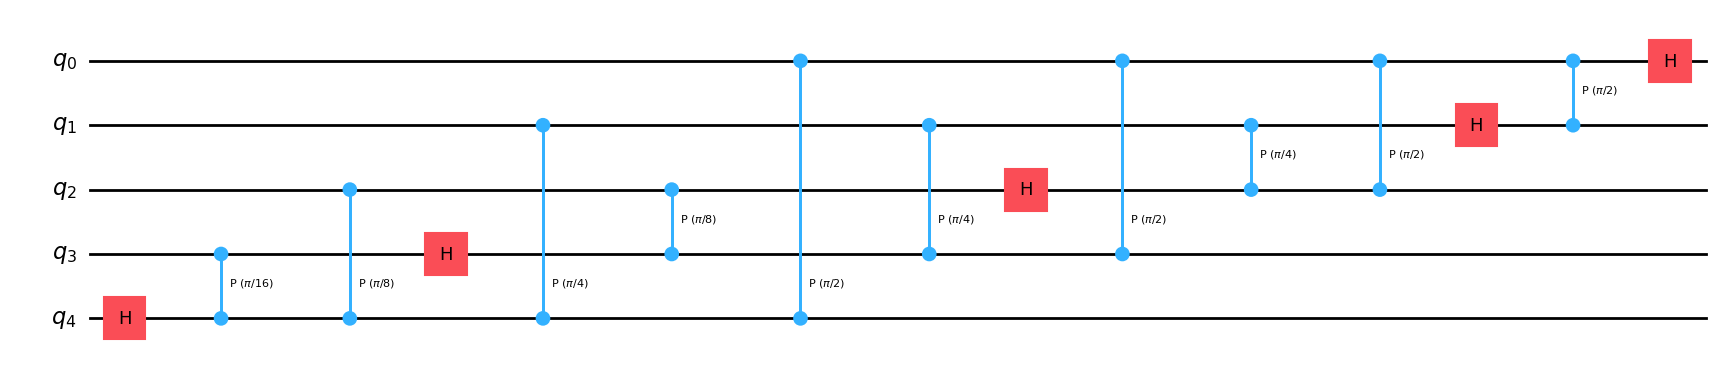

In [ ]:
qft(5).draw("mpl")

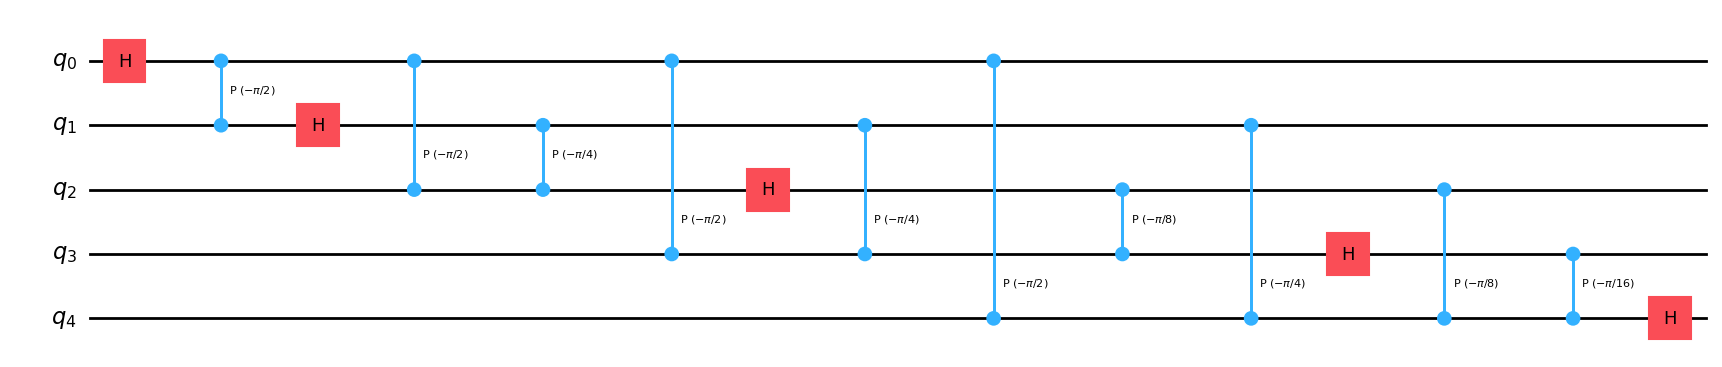

In [ ]:
qft(5).inverse().draw("mpl")

## Portas **Controladas**

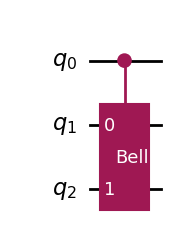

In [ ]:
# Cria uma versão controlada do Bell
# num_ctrl_qubits=1 define quantos controles teremos
ctrl_gate = bell_gate.control(num_ctrl_qubits=1)

qc = QuantumCircuit(3)

# Qubit 0 é o controle
# Qubits 1 e 2 são os alvos do entangler
qc.append(ctrl_gate, [0, 1, 2])

qc.draw("mpl")

## **Vetor** de Estados

In [ ]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
# Cria o estado a partir do circuito
# (O circuito não deve ter medições!)
sv = Statevector.from_instruction(qc)
# Visualização
sv.draw("latex")

<IPython.core.display.Latex object>

## Executando com **Sampler**


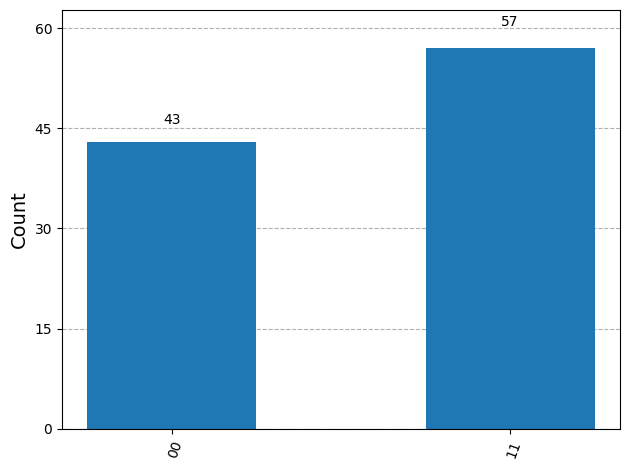

In [ ]:
qubits = QuantumRegister(2, name="qubits")
bits = ClassicalRegister(2, name="bits")

qc = QuantumCircuit(qubits, bits)
qc.h(0)
qc.cx(0, 1)

qc.measure([0, 1], [0, 1])

backend = AerSimulator()
pm = generate_preset_pass_manager(backend=backend)
isa_qc = pm.run(qc)

# 1. Instancia o Sampler apontando para o backend
sampler = Sampler(backend)

# 2. Executa o job
job = sampler.run([isa_qc], shots=100)

# 3. Obtém o resultado
result = job.result()

# Acessa os dados do primeiro (e único) circuito do job
result0 = result[0]

# "bits" é o nome do registrador clássico
counts = result0.data["bits"].get_counts()
plot_histogram(counts)

## Executando com **Estimator** (CHSH)


In [ ]:
qc = QuantumCircuit(2)
qc.x(range(2))
qc.h(0)
qc.cx(0, 1)

observable = SparsePauliOp.from_list([
    ("ZZ", -1 / np.sqrt(2)),
    ("ZX", -1 / np.sqrt(2)),
    ("ZX", +1 / np.sqrt(2)),
    ("ZZ", -1 / np.sqrt(2)),
    ("XZ", -1 / np.sqrt(2)),
    ("XX", -1 / np.sqrt(2)),
    ("XX", -1 / np.sqrt(2)),
    ("XZ", +1 / np.sqrt(2)),
])

backend = AerSimulator()
estimator = Estimator(backend)
pm = generate_preset_pass_manager(backend=backend)
isa_qc = pm.run(qc)
isa_observables = observable.apply_layout(isa_qc.layout)
result = estimator.run([(isa_qc, isa_observables)]).result()
exp_value = result[0].data.evs
print(exp_value)

2.82842712474619


## Circuitos **Parametrizados**


In [ ]:
theta = Parameter("θ")
qc = QuantumCircuit(1)
qc.h(0)
qc.rz(theta, 0)  # Rotação depende do parâmetro
qc.h(0)
angle_value = np.pi / 4  # Para rodar, atribuímos um valor ao parâmetro
observable = SparsePauliOp.from_list([("Z", 1.0)])
result = estimator.run([(qc, observable, [angle_value])]).result()
print(result[0].data.evs)

0.71484375


## Hardware Real: **IBM Quantum**


In [ ]:
# Carrega credenciais salvas
# service = QiskitRuntimeService(token="--------------------------------------------")

# Busca o computador quântico real menos ocupado
# backend = service.least_busy(operational=True, simulator=False)

# O resto segue igual:
# pm = generate_preset_pass_manager(backend=backend) ...
# sampler = Sampler(backend) ...

# CHSH em Ket

In [ ]:
# Descomente a próxima linha para instalar as dependências necessárias no Colab.
!pip install ket-lang[plot]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.0 MB/s eta 0:00:00


In [ ]:
from ket import Process, X, Z, H, CNOT, obs, exp_value

process = Process()
a, b = process.alloc(2)
X(a + b)
CNOT(H(a), b)

with obs():
    A0 = Z(a)
    A1 = X(a)
    B0 = -(X(b) + Z(b)) / np.sqrt(2)
    B1 = (X(b) - Z(b)) / np.sqrt(2)
    h = A0 * B0 + A0 * B1 + A1 * B0 - A1 * B1

print(exp_value(h).get())

2.8284267895146886


## 🧪 Exercício: Estado GHZ

Crie um circuito quântico que prepare um estado GHZ de 3 qubits

$$
\frac{|000\rangle + |111\rangle}{\sqrt{2}}
$$

e meça com o `Sampler`.  
Verifique se as contagens com um histograma 📊.

**Extra:** Generalize sua implementação para $n$ qubits  
e teste em um computador quântico real.


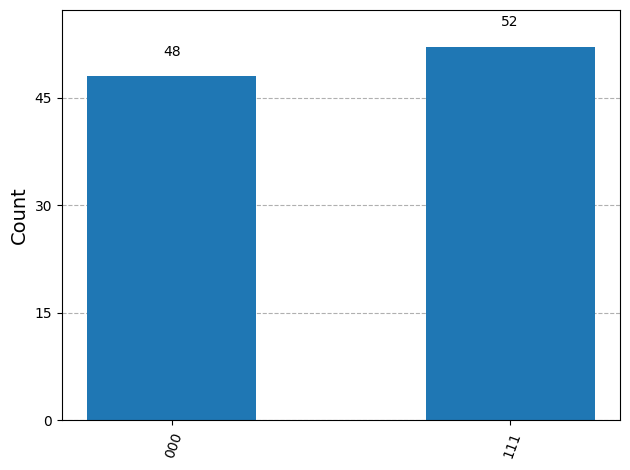

In [ ]:
qubits = QuantumRegister(3, name="q")
bits = ClassicalRegister(3, name="c")

qc = QuantumCircuit(qubits, bits)

qc.h([0])
qc.cx(0,1)
qc.cx(0,2)

sv = Statevector.from_instruction(qc)

# Visualização
sv.draw("latex")

# Adiciona medições para que o Sampler possa coletar os resultados
qc.measure(qubits, bits)

# Sampler
backend = AerSimulator()
sampler = Sampler(backend)
pm = generate_preset_pass_manager(backend=backend)

isa_qc = pm.run(qc)
job = sampler.run([isa_qc], shots=100)
result = job.result()
result0 = result[0]
counts = result0.data["c"].get_counts()

plot_histogram(counts)